# Multidigit Demo Pipeline
Pipeline demo ini menjalankan seluruh tahapan inference terbaik: preprocessing agresif untuk menetralkan citra dunia nyata, segmentasi digit adaptif, ekstraksi fitur HOG, dan klasifikasi SVM yang sudah dilatih. Setiap tahap divisualisasikan agar mudah melakukan debugging kualitas data lapangan.

## Agenda Demo
1. Muat artefak model & metadata primer.
2. Terapkan preprocessing untuk mereduksi noise (garis kertas, bayangan, warna).
3. Segmentasi adaptif + fallback proyeksi untuk memastikan setiap digit terpotong.
4. Ekstraksi HOG + klasifikasi SVM menghasilkan string multidigit.
5. Visualisasi lengkap (gambar, mask, histogram, bounding box).
6. Evaluasi batch dan sajikan tabel akurasi + histogram performa.

In [1]:
# Pasang dependency tambahan untuk demo (selain yang sudah dipasang oleh pipeline training)
%pip install --quiet ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Konfigurasi path, artefak, dan metadata primer
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output

plt.style.use('seaborn-v0_8-muted')
RSEED = 42

WORKSPACE = Path('.').resolve()
PRIMER_ROOT = WORKSPACE / 'primer_dataset'
PRIMER_IMG_DIR = PRIMER_ROOT / 'images'
PRIMER_LABELS = PRIMER_ROOT / 'primary_labels.csv'
ARTIFACT_PATH = WORKSPACE / 'artifacts' / 'svm_digit_classifier.joblib'
# ARTIFACT_PATH = WORKSPACE / 'svm_model.joblib'

for path_obj, desc in [
    (PRIMER_IMG_DIR, 'Folder gambar primer'),
    (PRIMER_LABELS, 'primary_labels.csv'),
    (ARTIFACT_PATH, 'Model SVM tersimpan')
]:
    assert path_obj.exists(), f"{desc} tidak ditemukan di {path_obj}"

primer_df = pd.read_csv(PRIMER_LABELS, dtype={'Id': str, 'Label': str, 'digit_count': int, 'usage': str})
primer_df['Id'] = primer_df['Id'].str.strip()
primer_df['Label'] = primer_df['Label'].str.strip()
primer_df['usage'] = primer_df['usage'].str.lower().str.strip()

artifact = joblib.load(ARTIFACT_PATH)
svm_model = artifact['model']
scaler = artifact['scaler']
HOG_PARAMS = artifact.get('hog_params', {
    'pixels_per_cell': (4, 4),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'transform_sqrt': True,
    'block_norm': 'L2-Hys'
})

def image_path_from_id(img_id: str | int) -> Path:
    return PRIMER_IMG_DIR / f"multidigit({str(img_id)}).png"

usage_summary = (
    primer_df.groupby('usage')
    .agg(sampel=('Id', 'count'), total_digit=('digit_count', 'sum'))
    .reset_index()
)
display(usage_summary)
print(f"Artefak dimuat dari: {ARTIFACT_PATH}")

AssertionError: Folder gambar primer tidak ditemukan di D:\Pembelajaran D-IV TI\SEM 5\Tugas Akhir\multidigit_recognition\backend\primer_dataset\images

In [ ]:
# Konstanta utilitas & helper umum
DIGIT_CANVAS_SIZE = 28
TARGET_DIGIT_EXTENT = 20
MIN_SEGMENT_AREA = 80
PROJECTION_PAD = 2
BBOX_PAD = 2  # perluasan bbox agar kontur tidak terpotong
OWNERSHIP_MARGIN = 3  # menjaga piksel tetap milik digit terdekatnya


def ensure_foreground_white(img: np.ndarray) -> np.ndarray:
    """Pastikan digit tampil putih di atas latar gelap."""
    return cv2.bitwise_not(img) if np.mean(img) > 127 else img


def normalize_uint8(img: np.ndarray) -> np.ndarray:
    """Normalisasi rentang piksel ke uint8 penuh."""
    img = img.astype(np.float32)
    if img.max() > img.min():
        img = (img - img.min()) / (img.max() - img.min()) * 255.0
    return img.astype(np.uint8)

In [ ]:
# Utility preprocessing agar domain lapangan ≈ data training
def remove_background_variation(gray: np.ndarray) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    bg = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    normalized = cv2.subtract(bg, gray)
    return normalized


def robust_preprocessing(image_bgr: np.ndarray) -> tuple[np.ndarray, float]:
    if image_bgr is None:
        raise ValueError("Input image kosong")
    if image_bgr.ndim == 3:
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    else:
        gray = image_bgr.copy()
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = remove_background_variation(gray)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    std_dev = float(np.std(enhanced))
    enhanced = ensure_foreground_white(enhanced)
    return enhanced, std_dev


def resize_and_center(
    img: np.ndarray,
    size: int = DIGIT_CANVAS_SIZE,
    target_extent: int = TARGET_DIGIT_EXTENT,
) -> np.ndarray:
    """Scale digit ke target_extent dan pusatkan pada kanvas MNIST-like."""
    if img is None or img.size == 0:
        return np.zeros((size, size), dtype=np.uint8)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = normalize_uint8(img)
    img = ensure_foreground_white(img)

    h, w = img.shape[:2]
    if h == 0 or w == 0:
        return np.zeros((size, size), dtype=np.uint8)
    scale = target_extent / max(h, w)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    interp = cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC
    digit = cv2.resize(img, (new_w, new_h), interpolation=interp)

    canvas = np.zeros((size, size), dtype=np.uint8)
    y_off = (size - new_h) // 2
    x_off = (size - new_w) // 2
    canvas[y_off : y_off + new_h, x_off : x_off + new_w] = digit

    m = cv2.moments(canvas)
    if abs(m['m00']) > 1e-6:
        cx = m['m10'] / m['m00']
        cy = m['m01'] / m['m00']
        shift_x = np.clip(int(round(size / 2 - cx)), -size, size)
        shift_y = np.clip(int(round(size / 2 - cy)), -size, size)
        shift_mat = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        canvas = cv2.warpAffine(canvas, shift_mat, (size, size), borderValue=0)

    return canvas

In [ ]:
# Segmentasi hybrid agar konsisten dengan pipeline training

def _build_clean_mask(img_clean: np.ndarray) -> np.ndarray:
    blur = cv2.GaussianBlur(img_clean, (3, 3), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    clean_mask = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    return clean_mask


def _split_with_projection(
    mask: np.ndarray,
    img_clean: np.ndarray,
    expected_digits: int,
    min_area: int,
 ) -> list[dict]:
    if expected_digits is None or expected_digits <= 0:
        return []
    h, w = mask.shape
    col_profile = mask.sum(axis=0).astype(np.float32)
    if col_profile.max() <= 0:
        return []
    cumsum = np.cumsum(col_profile)
    total = cumsum[-1]
    cut_points = [0]
    for k in range(1, expected_digits):
        target = total * k / expected_digits
        idx = int(np.searchsorted(cumsum, target, side='left'))
        cut_points.append(idx)
    cut_points.append(w)
    for i in range(1, len(cut_points)):
        cut_points[i] = int(np.clip(cut_points[i], cut_points[i - 1] + 1e-3, w))

    digits: list[dict] = []
    for i in range(expected_digits):
        x0 = max(0, cut_points[i] - PROJECTION_PAD)
        x1 = min(w, cut_points[i + 1] + PROJECTION_PAD)
        if x1 <= x0:
            continue
        sub_mask = mask[:, x0:x1]
        ys, xs = np.where(sub_mask > 0)
        if len(xs) == 0:
            y_min, y_max = 0, h
            x_min, x_max = x0, x1
        else:
            y_min, y_max = int(ys.min()), int(ys.max() + 1)
            x_min, x_max = int(x0 + xs.min()), int(x0 + xs.max() + 1)
        if (x_max - x_min) * (y_max - y_min) < min_area:
            pad = PROJECTION_PAD
            x_min = max(0, x_min - pad)
            x_max = min(w, x_max + pad)
            y_min = max(0, y_min - pad)
            y_max = min(h, y_max + pad)
        if BBOX_PAD > 0:
            x_min = max(0, x_min - BBOX_PAD)
            x_max = min(w, x_max + BBOX_PAD)
            y_min = max(0, y_min - BBOX_PAD)
            y_max = min(h, y_max + BBOX_PAD)

        digit_patch = img_clean[y_min:y_max, x_min:x_max]
        crop_28 = resize_and_center(digit_patch, size=DIGIT_CANVAS_SIZE)
        digits.append({'bbox': (x_min, y_min, x_max - x_min, y_max - y_min), 'crop': crop_28})
    return digits


def _build_ownership_mask(
    x0: int,
    y0: int,
    x1: int,
    y1: int,
    centroid: tuple[float, float],
    other_centroids: list[tuple[float, float]],
    margin_px: int = OWNERSHIP_MARGIN,
 ) -> np.ndarray:
    h = max(0, y1 - y0)
    w = max(0, x1 - x0)
    if h == 0 or w == 0:
        return np.zeros((0, 0), dtype=np.uint8)
    if margin_px <= 0 or not other_centroids:
        return np.ones((h, w), dtype=np.uint8) * 255
    yy, xx = np.indices((h, w), dtype=np.float32)
    abs_x = xx + float(x0)
    abs_y = yy + float(y0)
    dx_cur = abs_x - float(centroid[0])
    dy_cur = abs_y - float(centroid[1])
    dist_cur = dx_cur * dx_cur + dy_cur * dy_cur
    dist_other = np.full_like(dist_cur, np.inf)
    for other in other_centroids:
        dx_o = abs_x - float(other[0])
        dy_o = abs_y - float(other[1])
        dist_other = np.minimum(dist_other, dx_o * dx_o + dy_o * dy_o)
    margin_sq = float(margin_px * margin_px)
    ownership = dist_cur <= (dist_other - margin_sq)
    mask = np.where(ownership, 255, 0).astype(np.uint8)
    return mask


def segment_digits(
    img_clean: np.ndarray,
    expected_digits: int | None,
    min_area: int = MIN_SEGMENT_AREA,
 ) -> list[dict]:
    clean_mask = _build_clean_mask(img_clean)
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_h, img_w = img_clean.shape[:2]
    contour_infos: list[dict] = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < min_area:
            continue
        moments = cv2.moments(contour)
        if abs(moments['m00']) > 1e-6:
            cx = moments['m10'] / moments['m00']
            cy = moments['m01'] / moments['m00']
        else:
            cx = x + w / 2
            cy = y + h / 2
        contour_infos.append({'contour': contour, 'bbox': (x, y, w, h), 'centroid': (cx, cy)})

    contour_infos.sort(key=lambda info: info['bbox'][0])
    digits = []
    for info in contour_infos:
        contour = info['contour']
        x, y, w, h = info['bbox']
        if BBOX_PAD > 0:
            x0 = max(0, x - BBOX_PAD)
            y0 = max(0, y - BBOX_PAD)
            x1 = min(img_w, x + w + BBOX_PAD)
            y1 = min(img_h, y + h + BBOX_PAD)
        else:
            x0, y0, x1, y1 = x, y, x + w, y + h
        digit_patch = img_clean[y0:y1, x0:x1]
        if digit_patch.size == 0:
            continue
        contour_mask = np.zeros_like(digit_patch, dtype=np.uint8)
        cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED, offset=(-x0, -y0))
        if contour_mask.max() == 0:
            continue
        other_centroids = [c['centroid'] for c in contour_infos if c is not info]
        if other_centroids and OWNERSHIP_MARGIN > 0:
            ownership_mask = _build_ownership_mask(x0, y0, x1, y1, info['centroid'], other_centroids)
            contour_mask = cv2.bitwise_and(contour_mask, ownership_mask)
            if contour_mask.max() == 0:
                cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED, offset=(-x0, -y0))
        digit_patch = cv2.bitwise_and(digit_patch, digit_patch, mask=contour_mask)
        if digit_patch.max() == 0:
            digit_patch = img_clean[y0:y1, x0:x1]
        crop_28 = resize_and_center(digit_patch, size=DIGIT_CANVAS_SIZE)
        digits.append({'bbox': (x0, y0, x1 - x0, y1 - y0), 'crop': crop_28})

    if expected_digits is not None and expected_digits > 0 and len(digits) != expected_digits:
        projected = _split_with_projection(clean_mask, img_clean, expected_digits, min_area // 2)
        if projected:
            digits = projected

    return digits

In [ ]:
def _load_image(image_source):
    if isinstance(image_source, (str, Path)):
        img = cv2.imread(str(image_source), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Tidak bisa membaca gambar dari {image_source}")
        return img
    if isinstance(image_source, np.ndarray):
        return image_source
    raise TypeError("image_source harus berupa path atau numpy array")


def run_prediction_pipeline(
    image_source,
    expected_digits: int | None = None,
    context: dict | None = None,
):
    raw_img = _load_image(image_source)
    raw_gray = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY) if raw_img.ndim == 3 else raw_img.copy()
    cleaned, std_dev = robust_preprocessing(raw_img)
    clean_mask = _build_clean_mask(cleaned)
    crops = segment_digits(cleaned, expected_digits=expected_digits)
    records = []
    for idx, crop_dict in enumerate(crops):
        feat = hog(crop_dict['crop'], visualize=False, feature_vector=True, **HOG_PARAMS)
        feat_s = scaler.transform(feat.reshape(1, -1))
        pred = int(svm_model.predict(feat_s)[0])
        records.append({
            'index': idx,
            'bbox': crop_dict['bbox'],
            'crop': crop_dict['crop'],
            'prediction': pred,
        })
    predicted_digits = ''.join(str(r['prediction']) for r in records)
    result = {
        'path': str(image_source),
        'original_bgr': raw_img,
        'original_gray': raw_gray,
        'cleaned': cleaned,
        'mask': clean_mask,
        'std_dev': std_dev,
        'records': records,
        'prediction': predicted_digits,
        'expected_digits': expected_digits,
        'context': context or {},
    }
    return result

In [ ]:
def visualize_pipeline(result: dict, true_label: str | None = None):
    original_rgb = cv2.cvtColor(result['original_bgr'], cv2.COLOR_BGR2RGB) if result['original_bgr'].ndim == 3 else result['original_bgr']
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(original_rgb, cmap='gray')
    axes[0].set_title('Original RGB')
    axes[1].imshow(result['cleaned'], cmap='gray')
    axes[1].set_title('Preprocess (CLAHE + invert)')
    axes[2].imshow(result['mask'], cmap='gray')
    axes[2].set_title('Binary mask')
    axes[3].imshow(result['cleaned'], cmap='gray')
    for rec in result['records']:
        x, y, w, h = rec['bbox']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        axes[3].add_patch(rect)
        axes[3].text(x, max(0, y - 5), str(rec['prediction']), color='yellow', fontsize=10, weight='bold')
    axes[3].set_title('Bounding boxes + pred')
    for ax in axes:
        ax.axis('off')
    plt.suptitle(f"Prediksi: {result['prediction']}" + (f" | Label: {true_label}" if true_label else ''))
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    axes[0].hist(result['original_gray'].ravel(), bins=32, color='gray')
    axes[0].set_title('Histogram original')
    axes[1].hist(result['cleaned'].ravel(), bins=32, color='steelblue')
    axes[1].set_title('Histogram preprocess')
    axes[2].hist(result['mask'].ravel(), bins=32, color='darkorange')
    axes[2].set_title('Histogram mask')
    for ax in axes:
        ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    if result['records']:
        fig, axes = plt.subplots(1, len(result['records']), figsize=(3 * len(result['records']), 3))
        if len(result['records']) == 1:
            axes = [axes]
        for ax, rec in zip(axes, result['records']):
            ax.imshow(rec['crop'], cmap='gray')
            ax.set_title(f"Pred {rec['prediction']}")
            ax.axis('off')
        plt.suptitle('Digit crops 28×28')
        plt.tight_layout()
        plt.show()

def describe_prediction(result: dict, true_label: str | None = None):
    predicted = result['prediction'] or '(empty)'
    info = f"Predicted: {predicted}"
    if true_label is not None:
        info += f" | Ground truth: {true_label}"
        info += f" | Match: {predicted == true_label}"
    info += f" | Segmented digits: {len(result['records'])}"
    print(info)

Menjalankan demo pada Id=74 | Label=4353 | File=multidigit(74).png
Predicted: 9159 | Ground truth: 4353 | Match: False | Segmented digits: 4


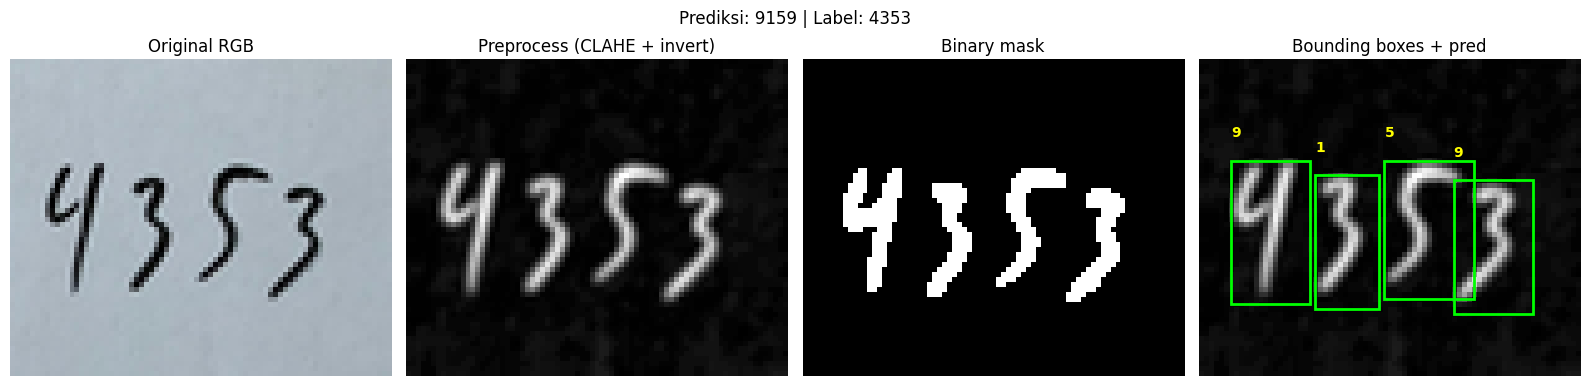

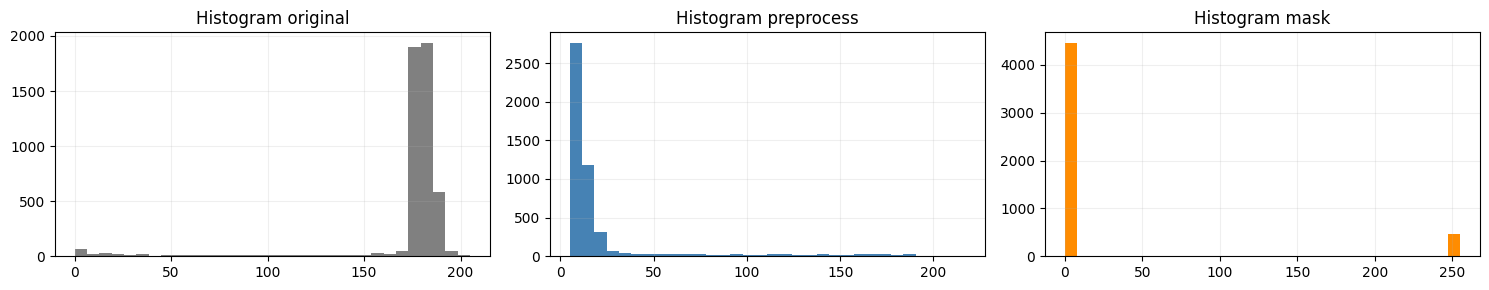

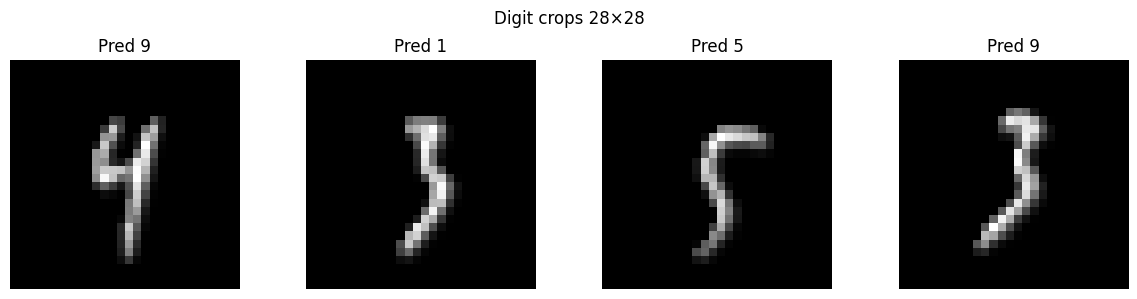

In [ ]:
rng = np.random.default_rng(RSEED)
sample_row = primer_df[primer_df['usage'] == 'test'].sample(n=1, random_state=RSEED).iloc[0]
sample_path = image_path_from_id(sample_row['Id'])
print(f"Menjalankan demo pada Id={sample_row['Id']} | Label={sample_row['Label']} | File={sample_path.name}")
demo_result = run_prediction_pipeline(sample_path, expected_digits=int(sample_row['digit_count']), context={'Id': sample_row['Id']})
describe_prediction(demo_result, true_label=sample_row['Label'])
visualize_pipeline(demo_result, true_label=sample_row['Label'])

Evaluasi demo:   0%|          | 0/30 [00:00<?, ?it/s]

,Id,usage,truth,prediction,correct,digit_count,segments,file,error
0,74,test,4353,9159,False,4,4,multidigit(74).png,None
1,19,test,24732,24732,True,5,5,multidigit(19).png,None
2,119,test,936,936,True,3,3,multidigit(119).png,None
3,79,test,9321,1821,False,4,4,multidigit(79).png,None
4,77,test,8844,8957,False,4,4,multidigit(77).png,None
5,32,test,7125,7125,True,4,4,multidigit(32).png,None
6,65,test,897,897,True,3,3,multidigit(65).png,None
7,142,test,902,902,True,3,3,multidigit(142).png,None
8,69,test,7134,4834,False,4,4,multidigit(69).png,None
9,83,test,9999,8214,False,4,4,multidigit(83).png,None


Akurasi keseluruhan: 0.633


,digit_count,samples,accuracy
0,2,3,1.000000
1,3,6,0.833333
2,4,14,0.500000
3,5,7,0.571429


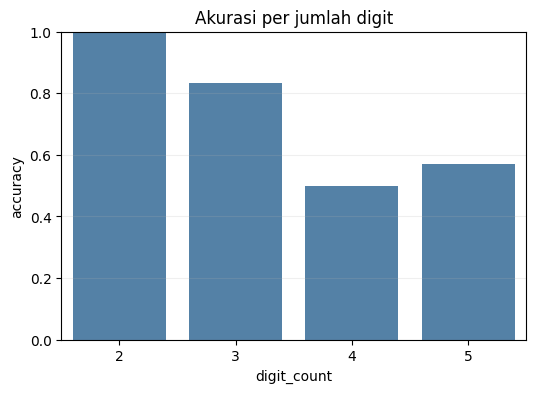

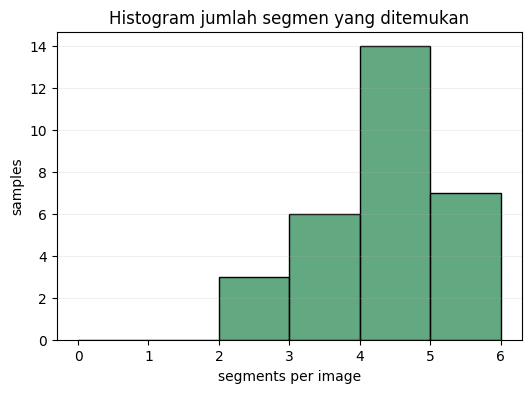

In [ ]:
from tqdm.auto import tqdm

def evaluate_batch(df: pd.DataFrame, usage: str = 'test', n_samples: int = 25):
    pool = df[df['usage'] == usage]
    if pool.empty:
        raise ValueError(f"Tidak ada data dengan usage={usage}")
    subset = pool.sample(n=min(n_samples, len(pool)), random_state=RSEED).reset_index(drop=True)
    records = []
    for row in tqdm(subset.itertuples(), total=len(subset), desc='Evaluasi demo'):
        img_path = image_path_from_id(row.Id)
        try:
            result = run_prediction_pipeline(img_path, expected_digits=int(row.digit_count))
            prediction = result['prediction']
            segmented = len(result['records'])
            error = None
        except Exception as exc:
            prediction = ''
            segmented = 0
            error = str(exc)
        records.append({
            'Id': row.Id,
            'usage': row.usage,
            'truth': row.Label,
            'prediction': prediction,
            'correct': prediction == row.Label,
            'digit_count': row.digit_count,
            'segments': segmented,
            'file': Path(img_path).name,
            'error': error
        })
    eval_df = pd.DataFrame(records)
    accuracy = eval_df['correct'].mean()
    per_count = (
        eval_df.groupby('digit_count')
        .agg(samples=('Id', 'count'), accuracy=('correct', 'mean'))
        .reset_index()
        .sort_values('digit_count')
    )
    return eval_df, accuracy, per_count

eval_df, overall_acc, per_digit_acc = evaluate_batch(primer_df, usage='test', n_samples=30)
display(eval_df)
print(f"Akurasi keseluruhan: {overall_acc:.3f}")
display(per_digit_acc)

plt.figure(figsize=(6, 4))
sns.barplot(data=per_digit_acc, x='digit_count', y='accuracy', color='steelblue')
plt.ylim(0, 1)
plt.title('Akurasi per jumlah digit')
plt.ylabel('accuracy')
plt.xlabel('digit_count')
plt.grid(axis='y', alpha=0.2)
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(eval_df['segments'], bins=range(0, eval_df['segments'].max() + 2), color='seagreen')
plt.title('Histogram jumlah segmen yang ditemukan')
plt.xlabel('segments per image')
plt.ylabel('samples')
plt.grid(axis='y', alpha=0.2)
plt.show()

In [ ]:
# Prediction demo interaktif berbasis upload file
accept_ext = '.png,.jpg,.jpeg,.bmp,.tif,.tiff'
upload_widget = widgets.FileUpload(
    accept=accept_ext,
    multiple=True,
    description='Upload gambar',
    style={'button_color': '#4caf50'}
)
output = widgets.Output()


def _iter_uploaded_files(value):
    if isinstance(value, dict):
        return list(value.values())
    if isinstance(value, tuple):
        return list(value)
    return []


def _file_token(file_info: dict) -> tuple:
    return (
        file_info.get('name'),
        file_info.get('last_modified'),
        file_info.get('size'),
    )


def _handle_upload(change):
    if change.get('name') != 'value':
        return
    new_files = _iter_uploaded_files(change.get('new', {}))
    if not new_files:
        return
    old_files = _iter_uploaded_files(change.get('old', {}))
    processed_tokens = {_file_token(info) for info in old_files}
    pending: list[dict] = []
    for file_info in new_files:
        token = _file_token(file_info)
        if token in processed_tokens:
            continue
        processed_tokens.add(token)
        pending.append(file_info)
    if not pending:
        return
    output.clear_output()
    with output:
        for file_info in pending:
            name = file_info.get('name', 'uploaded')
            bytes_data = file_info.get('content')
            if bytes_data is None:
                print(f"Konten kosong untuk {name}")
                continue
            buffer = np.frombuffer(bytes_data, dtype=np.uint8)
            img = cv2.imdecode(buffer, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Gagal membaca berkas {name}")
                continue
            print(f"\n=== {name} ===")
            result = run_prediction_pipeline(img, context={'filename': name})
            describe_prediction(result)
            visualize_pipeline(result)
    try:
        upload_widget.value = type(upload_widget.value)()
    except Exception:
        pass


upload_widget.observe(_handle_upload, names='value')
info = widgets.HTML(
    value=(
        '<b>Upload gambar multidigit (.png/.jpg/.jpeg/.bmp/.tif/.tiff)</b><br/>'
        'Setiap berkas yang diunggah langsung diproses melalui pipeline yang sama dengan training.'
    )
)
display(widgets.VBox([info, upload_widget, output]))